### Import Dependencies


In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import os
import nltk
import pickle

from sklearn.utils import resample
from textblob import TextBlob
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from collections import Counter
from google.colab import files
from google.colab import drive

import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import scipy.sparse

from scipy.stats import mode
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from scipy.sparse import issparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Conv1D, GlobalMaxPooling1D, Input, SimpleRNN, Reshape, Flatten, Concatenate, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Mount Datasets

In [ ]:
def load_slang_dict(file_path):
    slang_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            slang_dict[key.strip()] = value.strip()
    return slang_dict

def print_folder_structure(root_folder, indent=''):
    for item in os.listdir(root_folder):
        item_path = os.path.join(root_folder, item)
        print(indent + item)
        if os.path.isdir(item_path):
            print_folder_structure(item_path, indent + '    ')

#### Upload From Drive
1. Cek folder "KP 2024 - Ensemble Learning" di "Shared with me"
2. Klik kanan + pilih organize + add shortcut
3. Taro shortcut di MyDrive
4. isi path


In [ ]:
drive_path = '/content/drive'
host_path = drive_path + '/MyDrive/Shared/Projects/KP 2024 - Ensemble Learning/'
shared_path = drive_path + '/MyDrive/KP 2024 - Ensemble Learning/'

file_name = {
    'bbm': 'kenaikan_bbm_raw.csv',
    'pemilu': 'pemilu_raw.csv',
    'dict': 'slang_dict.txt'
}

drive.mount(drive_path, force_remount=True)

# DEBUG TOOL
# !ls /content/drive/
# !ls /content/drive/MyDrive

user_path = host_path
if not os.path.exists(user_path + file_name['bbm']):
  print(user_path + file_name['bbm'])
  user_path = shared_path

df_bbm = pd.read_csv(user_path + file_name['bbm']);
df_pemilu = pd.read_csv(user_path + file_name['pemilu']);
slang_dict = load_slang_dict(user_path + file_name['dict']);

ValueError: mount failed

In [ ]:
# Check drive structure for debugging
root_folder_path ='/content/drive'

# Print folder structure
# print("Folder structure:")
# print_folder_structure(root_folder_path)

# # Load datasets
# df_bbm = pd.read_csv('data/kenaikan_bbm_raw.csv')
# df_pemilu = pd.read_csv('data/pemilu_raw.csv')

In [ ]:
df_bbm.head()

,sentimen,text
0,NETRAL,@tanyarlfes Gaada bukti tapi dulu gw kalo nget...
1,NETRAL,@pcogovph Kayang kaya talaga paikutin ni Digon...
2,NEGATIF,@kpktemananies @musniumar Bajingany di mna om ...
3,NEGATIF,@m8deman @lovelyb1e Km yg ngomong ini pasti kr...
4,NEGATIF,@OposisiCerdas @venasantika Gaji besar bukanny...


In [ ]:
df_pemilu.head()

,Hasil,Tweet,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,barusan liat tulisan di belakang truk rela inj...,NaN,NaN,NaN
1,0,her itu lho miss kevin sama keven rebutan gimb...,NaN,NaN,NaN
2,0,iya rep gatau aku masih kelas 4 sd ehh di block,NaN,NaN,NaN
3,0,aku mohon tepatilah janjimu penantiancintaeps19,NaN,NaN,NaN
4,0,bukan beria nk kahwin sbb gatal celah kangkang...,NaN,NaN,NaN


In [ ]:
df_bbm['sentimen'].value_counts()

,count
sentimen,
NETRAL,4894
NEGATIF,2128
POSITIF,507


In [ ]:
df_pemilu['Hasil'].value_counts()

,count
Hasil,
0,15398
-1,14684
1,12610


In [ ]:
print(f"Jumlah baris dalam dataset BBM: {len(df_bbm)}")
print(f"Jumlah baris dalam dataset Pemilu: {len(df_pemilu)}")

Jumlah baris dalam dataset BBM: 7529
Jumlah baris dalam dataset Pemilu: 42692


### Preprocessing

In [ ]:
# TEST
df_bbm['sentimen'].value_counts()

,count
sentimen,
NETRAL,4894
NEGATIF,2128
POSITIF,507


In [ ]:
def replace_slang(text, slang_dict):
    words = text.split()
    replaced_text = ' '.join([slang_dict.get(word, word) for word in words])
    return replaced_text

def spell_checker(text):
    corrected_words = [str(TextBlob(word).correct()) for word in text.split()]
    return ' '.join(corrected_words)

def remove_stopwords(text):
    return stopword_remover.remove(text)

# Initialize Sastrawi stopword remover and stemmer
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

In [ ]:
# # Apply preprocessing to a sample of the datasets
# sample_size = 1000
# df_bbm_sample = df_bbm.sample(sample_size, random_state=42)
# df_pemilu_sample = df_pemilu.sample(sample_size, random_state=42)

from concurrent.futures import ProcessPoolExecutor
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 2


In [ ]:
def preprocess_text(text):

    if not isinstance(text, str):
      return ""

    # Normalize text
    text = text.lower()
    text = re.sub(r'^rt\b', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#|\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\b[a-z]{10,}\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\breply\b', '', text)

    # Replace slang words
    words = text.split()
    text = ' '.join([slang_dict.get(word, word) for word in words])

    # Remove stopwords and stem
    text = stopword_remover.remove(text)
    text = stemmer.stem(text)

    return text

# Function to process a chunk of the dataframe
def process_chunk(df_chunk):
    df_chunk['cleaned_text'] = df_chunk['text'].apply(preprocess_text)
    return df_chunk

def process_dataframe(df, text_column):
    num_cores = multiprocessing.cpu_count()
    df_split = np.array_split(df, num_cores)

    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        df_processed = pd.concat(executor.map(process_chunk, df_split))

    return df_processed

df_bbm = process_dataframe(df_bbm, 'text')
# df_pemilu = process_dataframe(df_pemilu, 'Tweet')

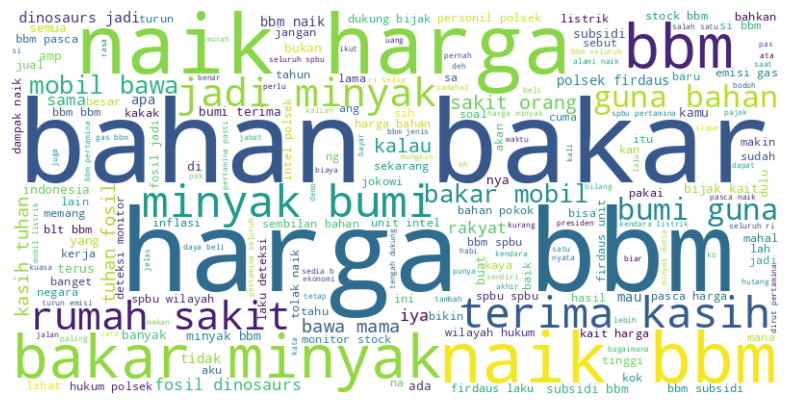

In [ ]:
# Function to create and display word cloud
def create_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Create word clouds
create_wordcloud(' '.join(df_bbm['cleaned_text']))
# create_wordcloud(' '.join(df_pemilu['cleaned_text']))

In [ ]:
# Function to find most common words
def find_common_words(texts, n=20):
    words = ' '.join(texts).split()
    return Counter(words).most_common(n)

# Find and print most common words
print("Most common words in BBM dataset:")
print(find_common_words(df_bbm['cleaned_text']))

# print("\nMost common words in Pemilu dataset:")
# print(find_common_words(df_pemilu['cleaned_text']))

Most common words in BBM dataset:
[('bbm', 7000), ('naik', 3419), ('harga', 2610), ('bahan', 1821), ('bakar', 1674), ('minyak', 1656), ('jadi', 1445), ('bumi', 1193), ('orang', 904), ('rakyat', 866), ('subsidi', 838), ('pertamina', 824), ('mobil', 812), ('guna', 705), ('rumah', 658), ('kasih', 617), ('terima', 612), ('fosil', 610), ('bawa', 607), ('kalau', 584)]


In [ ]:
# Save preprocessed datasets
df_bbm.to_csv(user_path + 'bbm_preprocessed_unbalanced.csv', index=False)
# df_pemilu.to_csv('data/pemilu_preprocessed.csv', index=False)

### Feature Extraction

In [ ]:
# Download preprocessed datasets
files.download(user_path + 'bbm_preprocessed_unbalanced.csv')
# files.download('data/pemilu_preprocessed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Load preprocessed data
df_bbm = pd.read_csv(user_path + '/bbm_preprocessed_unbalanced.csv')
# df_pemilu = pd.read_csv('data/pemilu_preprocessed.csv')
df_bbm['sentimen'].value_counts()

,count
sentimen,
NETRAL,4894
NEGATIF,2128
POSITIF,507


In [ ]:
df_bbm['cleaned_text'] = df_bbm['cleaned_text'].replace('', np.nan)
df_bbm = df_bbm.dropna(subset=['cleaned_text'])
print("Number of NaN values:", df_bbm['cleaned_text'].isna().sum())

Number of NaN values: 0


In [ ]:
X = df_bbm['cleaned_text']
y = df_bbm['sentimen']

# Split the data
X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [ ]:
# oversampler = RandomOverSampler(sampling_strategy={
#     'NETRAL': 3865,
#     'NEGATIF': 2000,
#     'POSITIF': 2000
# }, random_state=RANDOM_SEED)

oversampler = RandomOverSampler(random_state=RANDOM_SEED)
X_train, y_train = oversampler.fit_resample(X_train_unbalanced.values.reshape(-1, 1), y_train_unbalanced)

X_train = pd.Series(X_train.flatten())
y_train = pd.Series(y_train)
X_train = X_train.fillna('').astype(str)
X_test = X_test.fillna('').astype(str)

In [ ]:
print("ORIGINAL DISTRIBUTION")
print(y.value_counts())

print("\nRESAMPLED TRAIN")
print(y_train.value_counts())

print("\nTEST W DISTRIBUTION")
print(y_test.value_counts())

print("\nSHAPEZ")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

ORIGINAL DISTRIBUTION
sentimen
NETRAL     4842
NEGATIF    2127
POSITIF     507
Name: count, dtype: int64

RESAMPLED TRAIN
sentimen
NEGATIF    3873
NETRAL     3873
POSITIF    3873
Name: count, dtype: int64

TEST W DISTRIBUTION
sentimen
NETRAL     969
NEGATIF    426
POSITIF    101
Name: count, dtype: int64

SHAPEZ
(11619,)
(11619,)
(1496,)
(1496,)


In [ ]:
# Bag of Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [ ]:
# TF-IDF with different configurations
tfidf_vectorizer_1 = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_vectorizer_2 = TfidfVectorizer(max_features=2000, ngram_range=(1, 3))

X_train_tfidf_1 = tfidf_vectorizer_1.fit_transform(X_train)
X_test_tfidf_1 = tfidf_vectorizer_1.transform(X_test)

X_train_tfidf_2 = tfidf_vectorizer_2.fit_transform(X_train)
X_test_tfidf_2 = tfidf_vectorizer_2.transform(X_test)

In [ ]:
# Word2Vec with different configurations
w2v_model_cbow = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4, sg=0)  # CBOW
w2v_model_skipgram = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4, sg=1)  # Skip-gram

def get_w2v_features(texts, model):
    features = []
    for text in texts:
        words = text.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            features.append(np.mean(word_vectors, axis=0))
        else:
            features.append(np.zeros(model.vector_size))
    return np.array(features)

X_train_w2v_cbow = get_w2v_features(X_train, w2v_model_cbow)
X_test_w2v_cbow = get_w2v_features(X_test, w2v_model_cbow)

X_train_w2v_skipgram = get_w2v_features(X_train, w2v_model_skipgram)
X_test_w2v_skipgram = get_w2v_features(X_test, w2v_model_skipgram)

In [ ]:
# # BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# def get_bert_features(texts, tokenizer, model):
#     features = []
#     for text in texts:
#         inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
#         with torch.no_grad():
#             outputs = model(**inputs)
#         features.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
#     return np.array(features)

# X_train_bert = get_bert_features(X_train, tokenizer, model)
# X_test_bert = get_bert_features(X_test, tokenizer, model)

### Machine Learning (Independent)


#### Tentang NB
- Mungkin untuk tf-idf sama bow bisa pakai MultinomialNB, sedangkan word2vec dan BERT pakai GaussianNB
- Difference between NB classifiers https://stackoverflow.com/questions/48580762/difference-of-three-naive-bayes-classifiers
- Kayanya lebih bagus pake Gaussian karenna dataset lebih ke continuous(?)

In [ ]:
# Helper function to safely convert to dense array
def safe_dense(X):
    if issparse(X):
        return X.toarray()
    return X

In [ ]:
# Wrapper for GaussianNB to handle sparse input
class SparseGaussianNB(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = GaussianNB()
        self.scaler = StandardScaler(with_mean=False)

    def fit(self, X, y):
        X_dense = safe_dense(X)
        X_scaled = self.scaler.fit_transform(X_dense)
        self.model.fit(X_scaled, y)
        return self

    def predict(self, X):
        X_dense = safe_dense(X)
        X_scaled = self.scaler.transform(X_dense)
        return self.model.predict(X_scaled)

In [ ]:
# Define a list of models
ml_models = {
    'Sparse Gaussian NB': SparseGaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression()
}

# Define list of methods
methods = {
    'TF-IDF_1': (X_train_tfidf_1, X_test_tfidf_1),
    'TF-IDF_2': (X_train_tfidf_2, X_test_tfidf_2),
    'BOW': (X_train_bow, X_test_bow),
    'Word2Vec_CBOW': (X_train_w2v_cbow, X_test_w2v_cbow),
    'Word2Vec_SkipGram': (X_train_w2v_skipgram, X_test_w2v_skipgram),
    # 'BERT': (X_train_bert, X_test_bert)
}

In [ ]:
# Initialize an empty list to store results
ml_results = []

# Evaluate models for each method
for method, (X_train_method, X_test_method) in methods.items():
    for ml_name, model in ml_models.items():
        try:
            if ml_name == 'Multinomial NB' and 'Word2Vec' in method:
                continue  # Skip MultinomialNB for Word2Vec
            model.fit(X_train_method, y_train)
            y_pred = model.predict(X_test_method)
            accuracy = accuracy_score(y_test, y_pred)
            ml_results.append({'Model': ml_name, 'Method': method, 'Accuracy': accuracy})
        except Exception as e:
            print(f"Error occurred for {method} with model {ml_name}: {str(e)}")

        # print(f"\n{ml_name} Results:\n{classification_report(y_test, y_pred)}")

In [ ]:
# Create a DataFrame from results
ml_results_df = pd.DataFrame(ml_results)
ml_df = ml_results_df.pivot(index='Model', columns='Method', values='Accuracy')
print(ml_df)

Method                    BOW  TF-IDF_1  TF-IDF_2  Word2Vec_CBOW  \
Model                                                              
Decision Tree        0.842246  0.833556  0.835561       0.796123   
KNN                  0.834893  0.737968  0.737968       0.797460   
Logistic Regression  0.862299  0.864305  0.874332       0.830882   
Multinomial NB       0.807487  0.802807  0.825535            NaN   
SVM                  0.881684  0.888369  0.887032       0.848262   
Sparse Gaussian NB   0.681150  0.561497  0.698529       0.677807   

Method               Word2Vec_SkipGram  
Model                                   
Decision Tree                 0.799465  
KNN                           0.826872  
Logistic Regression           0.833556  
Multinomial NB                     NaN  
SVM                           0.850267  
Sparse Gaussian NB            0.721925  


### Machine Learning (Ensemble)


In [ ]:
# Define ensemble models with random_state
ensemble_base_models = {
    'SVM': SVC(probability=True, random_state=RANDOM_SEED),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED)
}

## Naive Bayes ga dimasukkan

In [ ]:
# VotingClassifier configurations
voting_hard = VotingClassifier(estimators=list(ensemble_base_models.items()), voting='hard')
voting_soft = VotingClassifier(estimators=list(ensemble_base_models.items()), voting='soft')

# StackingClassifier configurations
stacking_lr = StackingClassifier(
    estimators=list(ensemble_base_models.items()),
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_rf = StackingClassifier(
    estimators=list(ensemble_base_models.items()),
    final_estimator=RandomForestClassifier(n_estimators=100),
    cv=5
)

stacking_svm = StackingClassifier(
    estimators=list(ensemble_base_models.items()),
    final_estimator=SVC(probability=True),
    cv=5
)

stacking_gb = StackingClassifier(
    estimators=list(ensemble_base_models.items()),
    final_estimator=GradientBoostingClassifier(),
    cv=5
)

In [ ]:
# Define a list of models

stacking_models = {
    'Stacking_LR': stacking_lr,
    'Stacking_RF': stacking_rf,
    'Stacking_SVM': stacking_svm,
    'Stacking_GB': stacking_gb
}

voting_models = {
    'Voting_Hard': voting_hard,
    'Voting_Soft': voting_soft,
}

ensemble_models = {
    **stacking_models,
    **voting_models
}

In [ ]:
# Initialize an empty list to store results
ensemble_results = []

# Evaluate ensembles for each method
for method_name, (X_train_method, X_test_method) in methods.items():
    for ensemble_name, ensemble_model in ensemble_models.items():
        try:
            ensemble_model.fit(X_train_method, y_train)
            y_pred = ensemble_model.predict(X_test_method)
            accuracy = accuracy_score(y_test, y_pred)
            ensemble_results.append({'Model': ensemble_name, 'Method': method_name, 'Accuracy': accuracy})
        except Exception as e:
            print(f"Error occurred for {method_name} with model {ensemble_name}: {str(e)}")
      # print(f"\n{ensemble_name} Results:\n{classification_report(y_test, y_pred)}")

In [ ]:
# Create a DataFrame from results
ensemble_results_df = pd.DataFrame(ensemble_results)
ensemble_df = ensemble_results_df.pivot(index='Model', columns='Method', values='Accuracy')

print(ensemble_df)

Method             BOW  TF-IDF_1  TF-IDF_2  Word2Vec_CBOW  Word2Vec_SkipGram
Model                                                                       
Stacking_GB   0.868984  0.862299  0.855615       0.849599           0.850936
Stacking_LR   0.886364  0.874332  0.875668       0.849599           0.856952
Stacking_RF   0.862968  0.862968  0.845588       0.838904           0.856952
Stacking_SVM  0.868984  0.864973  0.858957       0.837567           0.856952
Voting_Hard   0.876337  0.886364  0.886364       0.848930           0.859626
Voting_Soft   0.886364  0.872326  0.875668       0.855615           0.864305


### Combined Result - Machine Learning


In [ ]:
ml_combined_results_df = pd.concat([ml_results_df, ensemble_results_df], ignore_index=True)
ml_combine_df = ml_combined_results_df.pivot(index='Model', columns='Method', values='Accuracy')

print(ml_combine_df)

Method                    BOW  TF-IDF_1  TF-IDF_2  Word2Vec_CBOW  \
Model                                                              
Decision Tree        0.842246  0.833556  0.835561       0.796123   
KNN                  0.834893  0.737968  0.737968       0.797460   
Logistic Regression  0.862299  0.864305  0.874332       0.830882   
Multinomial NB       0.807487  0.802807  0.825535            NaN   
SVM                  0.881684  0.888369  0.887032       0.848262   
Sparse Gaussian NB   0.681150  0.561497  0.698529       0.677807   
Stacking_GB          0.868984  0.862299  0.855615       0.849599   
Stacking_LR          0.886364  0.874332  0.875668       0.849599   
Stacking_RF          0.862968  0.862968  0.845588       0.838904   
Stacking_SVM         0.868984  0.864973  0.858957       0.837567   
Voting_Hard          0.876337  0.886364  0.886364       0.848930   
Voting_Soft          0.886364  0.872326  0.875668       0.855615   

Method               Word2Vec_SkipGram  
Model 

In [ ]:
# Highest accuracy for each method
highest_accuracy_models = ml_combine_df.idxmax()
print("Highest Accuracy Models for Each Method:")
print(highest_accuracy_models)

Highest Accuracy Models for Each Method:
Method
BOW                  Stacking_LR
TF-IDF_1                     SVM
TF-IDF_2                     SVM
Word2Vec_CBOW        Voting_Soft
Word2Vec_SkipGram    Voting_Soft
dtype: object


In [ ]:
# Highest average accuracy
mean_accuracies = ml_combine_df.mean(axis=1)
highest_average_method = mean_accuracies.idxmax()
highest_average_accuracy = mean_accuracies.max()
print(f"\nHighest Average Accuracy Method: {highest_average_method}")
print(f"Average Accuracy: {highest_average_accuracy}")


Highest Average Accuracy Method: Voting_Hard
Average Accuracy: 0.8715240641711229


## Deeplearning

### Glove Usage Reference (Embedding)


[disini](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) dia make word embedding glove:
1. glove -> dictionary global, ada banyak kata
2. filter dulu sesuai word yang ada di dataset dia
3. jadiin matrix
4. matrix di pake di layer embedding

untuk sekarang, w masih coba-coba, jadi ngikutin 100% flownya dia dulu
1. bikin dict
2. filter world (ga perlu karena w2v local berdasarkan dataset)
3. jadiin matrix
4. pake di layer embedding


In [ ]:
# # # CODE REFERENCE
# # Prepare data for DL models
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)
# X_seq = tokenizer.texts_to_sequences(X_train)
# X_pad = pad_sequences(X_seq)

# # Convert labels to numerical format
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_train)
# y_categorical = to_categorical(y_encoded)

# # # CODE REFERENCE
# # Word2Vec with different configurations
# w2v_model_cbow = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4, sg=0)  # CBOW
# w2v_model_skipgram = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4, sg=1)  # Skip-gram

# def get_w2v_features(texts, model):
#     features = []
#     for text in texts:
#         words = text.split()
#         word_vectors = [model.wv[word] for word in words if word in model.wv]
#         if word_vectors:
#             features.append(np.mean(word_vectors, axis=0))
#         else:
#             features.append(np.zeros(model.vector_size))
#     return np.array(features)

# X_train_w2v_cbow = get_w2v_features(X_train, w2v_model_cbow)
# X_test_w2v_cbow = get_w2v_features(X_test, w2v_model_cbow)

# X_train_w2v_skipgram = get_w2v_features(X_train, w2v_model_skipgram)
# X_test_w2v_skipgram = get_w2v_features(X_test, w2v_model_skipgram)

# # KODE DARI LINK -> WORKS
# model = Sequential()
# e = Embedding(input_dim=shape["rows"], output_dim=shape['cols'], weights=[embedding_matrix], input_length=X_train_pad.shape[1], trainable=False)
# model.add(e)
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

# Example sentences for training
sentences = [['this', 'is', 'a', 'sample'], ['we', 'are', 'learning', 'word2vec']]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create a dictionary of word vectors
word_vectors_dict = {word: model.wv[word].tolist() for word in model.wv.index_to_key}

# Print the dictionary
for word, vector in word_vectors_dict.items():
    vector_str = " ".join(map(str, vector))
    print(f"{word}: {vector_str}")

word2vec: -0.0005362272495403886 0.0002364313550060615 0.005103349685668945 0.009009272791445255 -0.009302949532866478 -0.007116809021681547 0.006458872463554144 0.008972988463938236 -0.005015428178012371 -0.0037633716128766537 0.007380504626780748 -0.0015334713971242309 -0.00453661335632205 0.006554051768034697 -0.004860160406678915 -0.0018160176696255803 0.002876579761505127 0.000991873792372644 -0.008285215124487877 -0.009448817931115627 0.0073117660358548164 0.005070262122899294 0.006757693365216255 0.0007628655293956399 0.006350890267640352 -0.0034053658600896597 -0.0009464013855904341 0.005768573377281427 -0.007521637715399265 -0.003936103545129299 -0.007511582225561142 -0.0009300422389060259 0.009538118727505207 -0.007319166790693998 -0.002333768643438816 -0.001937741064466536 0.008077437058091164 -0.005930895917117596 4.516244007390924e-05 -0.0047537339851260185 -0.009603550657629967 0.005007293075323105 -0.008759585209190845 -0.004391825292259455 -3.5099983506370336e-05 -0.000

In [ ]:
print(type(X_train_seq))
print(len(X_train_seq))
print(type(X_train_w2v_cbow))
print(type(X_test_w2v_cbow))
print("shape: ", X_train_w2v_cbow.shape)
print("content: \n", X_test_w2v_cbow)
print(w2v_model_cbow)
print(X_train_bow.toarray())
print(type(X_train_tfidf_1))
print(type(X_train_tfidf_2))

NameError: name 'X_train_seq' is not defined

In [ ]:
def get_embedding_matrix(tokenizer, method, vector_size=100):
    model_dict = {word: method.wv[word].tolist() for word in method.wv.index_to_key}
    cols = vector_size
    rows = len(model_dict) + 1
    print(rows)
    embedding_matrix = np.zeros((rows, cols))
    for word, i in tokenizer.word_index.items():
        embedding_vector = model_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, rows, cols

def print_dict(dic, n=10):
    for i, (word, vector) in enumerate(dic.items()):
      if i >= n:
        break
      vector_str = " ".join(map(str, vector))
      print(f"{word}: {vector_str}")

### Multiple Input Reference (Non Embedding)


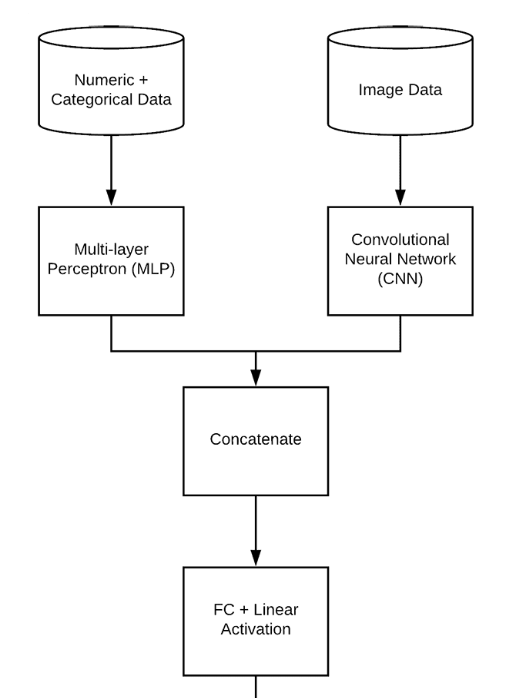

In [ ]:
# # define two sets of inputs
# inputA = Input(shape=(32,))
# inputB = Input(shape=(128,))
# # the first branch operates on the first input
# x = Dense(8, activation="relu")(inputA)
# x = Dense(4, activation="relu")(x)
# x = Model(inputs=inputA, outputs=x)
# # the second branch opreates on the second input
# y = Dense(64, activation="relu")(inputB)
# y = Dense(32, activation="relu")(y)
# y = Dense(4, activation="relu")(y)
# y = Model(inputs=inputB, outputs=y)
# # combine the output of the two branches
# combined = concatenate([x.output, y.output])
# # apply a FC layer and then a regression prediction on the
# # combined outputs
# z = Dense(2, activation="relu")(combined)
# z = Dense(1, activation="linear")(z)
# # our model will accept the inputs of the two branches and
# # then output a single value
# model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
# REFERENCE
# Code Reference https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# CREATE MLP BRANCH
# # import the necessary packages
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Input
# from tensorflow.keras.models import Model
# def create_mlp(dim, regress=False):
# 	# define our MLP network
# 	model = Sequential()
# 	model.add(Dense(8, input_dim=dim, activation="relu"))
# 	model.add(Dense(4, activation="relu"))
# 	# check to see if the regression node should be added
# 	if regress:
# 		model.add(Dense(1, activation="linear"))
# 	# return our model
# 	return model

# CREATE CNN BRANCH
# def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
# 	# initialize the input shape and channel dimension, assuming
# 	# TensorFlow/channels-last ordering
# 	inputShape = (height, width, depth)
# 	chanDim = -1
# 	# define the model input
# 	inputs = Input(shape=inputShape)
# 	# loop over the number of filters
# 	for (i, f) in enumerate(filters):
# 		# if this is the first CONV layer then set the input
# 		# appropriately
# 		if i == 0:
# 			x = inputs
# 		# CONV => RELU => BN => POOL
# 		x = Conv2D(f, (3, 3), padding="same")(x)
# 		x = Activation("relu")(x)
# 		x = BatchNormalization(axis=chanDim)(x)
# 		x = MaxPooling2D(pool_size=(2, 2))(x)
#     # flatten the volume, then FC => RELU => BN => DROPOUT
#     x = Flatten()(x)
#     x = Dense(16)(x)
#     x = Activation("relu")(x)
#     x = BatchNormalization(axis=chanDim)(x)
#     x = Dropout(0.5)(x)
#     # apply another FC layer, this one to match the number of nodes
#     # coming out of the MLP
#     x = Dense(4)(x)
#     x = Activation("relu")(x)
#     # check to see if the regression node should be added
#     if regress:
#       x = Dense(1, activation="linear")(x)
#     # construct the CNN
#     model = Model(inputs, x)
#     # return the CNN
#     return model

# COMBINE BRANCHES
# # create the MLP and CNN models
# mlp = models.create_mlp(trainAttrX.shape[1], regress=False)
# cnn = models.create_cnn(64, 64, 3, regress=False)
# # create the input to our final set of layers as the *output* of both
# # the MLP and CNN
# combinedInput = concatenate([mlp.output, cnn.output])
# # our final FC layer head will have two dense layers, the final one
# # being our regression head
# x = Dense(4, activation="relu")(combinedInput)
# x = Dense(1, activation="linear")(x)
# # our final model will accept categorical/numerical data on the MLP
# # input and images on the CNN input, outputting a single value (the
# # predicted price of the house)
# model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [ ]:
# REFERENCE
# # compile the model using mean absolute percentage error as our loss,
# # implying that we seek to minimize the absolute percentage difference
# # between our price *predictions* and the *actual prices*
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
# model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# # train the model
# print("[INFO] training model...")
# model.fit(
# 	x=[trainAttrX, trainImagesX], y=trainY,
# 	validation_data=([testAttrX, testImagesX], testY),
# 	epochs=200, batch_size=8)
# # make predictions on the testing data
# print("[INFO] predicting house prices...")
# preds = model.predict([testAttrX, testImagesX])

# # Train and evaluate deep learning models
# dl_models = {
#     'LSTM': create_lstm_model,
#     'CNN': create_cnn_model,
#     'BiLSTM': create_bilstm_model,
#     'RNN': create_rnn_model
# }

# def create_bilstm_model(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         Reshape((-1, 1)) if len(input_shape) == 1 else Lambda(lambda x: x),
#         Bidirectional(LSTM(64)),
#         Dense(3, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# def create_rnn_model(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         Reshape((-1, 1)) if len(input_shape) == 1 else Lambda(lambda x: x),
#         SimpleRNN(64),
#         Dense(3, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

### Current Implementation (Embedding + Non Embedding)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, padding='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=X_train_pad.shape[1], padding='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_categorical = to_categorical(y_train_encoded)

In [ ]:
def get_embedding_matrix(tokenizer, method, vector_size=100):
    model_dict = {word: method.wv[word].tolist() for word in method.wv.index_to_key}
    cols = vector_size
    rows = len(model_dict) + 1
    print(rows)
    embedding_matrix = np.zeros((rows, cols))
    for word, i in tokenizer.word_index.items():
        embedding_vector = model_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, rows, cols

def print_dict(dic, n=10):
    for i, (word, vector) in enumerate(dic.items()):
      if i >= n:
        break
      vector_str = " ".join(map(str, vector))
      print(f"{word}: {vector_str}")

In [ ]:
# Initialize word embeddings dictionary
word_embeddings = {}

# List of methods for iteration
methods = {
    "Word2Vec_CBOW": w2v_model_cbow,
    "Word2Vec_SkipGram": w2v_model_skipgram
}

# Create embedding matrices and store them in the word_embeddings dictionary
for method_name, method in methods.items():
    embedding_matrix, rows, cols = get_embedding_matrix(tokenizer, method, vector_size=100)
    word_embeddings[f"{method_name}"] = {
        "matrix": embedding_matrix,
        "rows": rows,
        "cols": cols
    }

non_embeddings = {
    "BOW": {
        "train": X_train_bow.toarray(),
        "test": X_test_bow.toarray()
    },
    "TF-IDF_1": {
        "train": X_train_tfidf_1.toarray(),
        "test": X_test_tfidf_1.toarray()
    },
    "TF-IDF_2": {
        "train": X_train_tfidf_2.toarray(),
        "test": X_test_tfidf_2.toarray()
    }
}

11071
11071


In [ ]:
def create_lstm_branch(input_dim, output_dim, input_length, embedding_matrix=None):
    inputs = Input(shape=(input_length,))
    if embedding_matrix is not None:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs)
    else:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(64, return_sequences=False)(x)
    return Model(inputs=inputs, outputs=x)

def create_cnn_branch(input_dim, output_dim, input_length, embedding_matrix=None):
    inputs = Input(shape=(input_length,))
    if embedding_matrix is not None:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs)
    else:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    return Model(inputs=inputs, outputs=x)

def create_bilstm_branch(input_dim, output_dim, input_length, embedding_matrix=None):
    inputs = Input(shape=(input_length,))
    if embedding_matrix is not None:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs)
    else:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    return Model(inputs=inputs, outputs=x)

def create_rnn_branch(input_dim, output_dim, input_length, embedding_matrix=None):
    inputs = Input(shape=(input_length,))
    if embedding_matrix is not None:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs)
    else:
        x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = SimpleRNN(64)(x)
    return Model(inputs=inputs, outputs=x)

def create_feature_branch(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation="relu")(inputs)
    return Model(inputs=inputs, outputs=x)

In [ ]:
dl_models = {
    'LSTM': create_lstm_branch,
    'CNN': create_cnn_branch,
    'BiLSTM': create_bilstm_branch,
    'RNN': create_rnn_branch
}

#### Flowchart

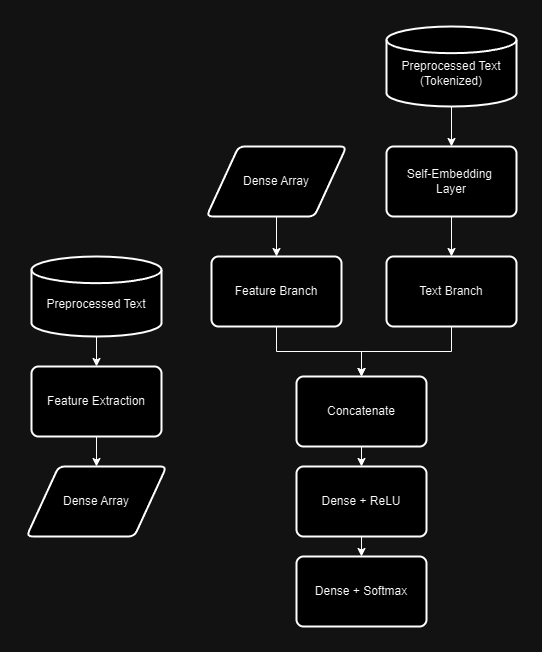


In [ ]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of X_test_pad: {X_test_pad.shape}")

Shape of X_test: (1496,)
Shape of X_test_pad: (1496, 59)


In [ ]:
dl_results = []

# Iterate over each model and non-embedding feature set
for model_name, create_model_fn in dl_models.items():
    for key, data in non_embeddings.items():
        print(f"Training {model_name} with {key} features")

        # Define branches
        text_model = create_model_fn(len(tokenizer.word_index) + 1, 128, X_train_pad.shape[1])
        feature_model = create_feature_branch(data["train"].shape[1])

        # Combine the branches
        combined = Concatenate()([text_model.output, feature_model.output])
        z = Dense(32, activation="relu")(combined)
        z = Dense(3, activation="softmax")(z)
        model = Model(inputs=[text_model.input, feature_model.input], outputs=z)

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(
            x=[X_train_pad, data["train"]], y=y_train_categorical,
            epochs=10, batch_size=32, validation_split=0.2
        )

        # Evaluate the model on the test set
        y_pred = model.predict([X_test_pad, data["test"]])
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = label_encoder.transform(y_test)
        accuracy = np.mean(y_pred_classes == y_test_classes)

        # Log the results
        dl_results.append({
            'Model': f'DL_{model_name}',
            'Method': key,
            'Accuracy': accuracy
        })

        # Print classification report
        print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


Training LSTM with BOW features
Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.7451 - loss: 0.6454 - val_accuracy: 0.9092 - val_loss: 0.2492
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.9409 - loss: 0.1740 - val_accuracy: 0.9729 - val_loss: 0.0633
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.9696 - loss: 0.0877 - val_accuracy: 0.9892 - val_loss: 0.0320
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.9791 - loss: 0.0585 - val_accuracy: 0.9892 - val_loss: 0.0242
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.9845 - loss: 0.0458 - val_accuracy: 0.9940 - val_loss: 0.0204
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9863 - loss: 0.0390 - val_accuracy: 0.9940 - val_loss: 0.0219
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.9864 - loss: 0.0363 - val_accuracy: 0.9940 - val_loss: 0.0209
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - 

In [ ]:
for model_name, create_model in dl_models.items():
    for method_name, embedding_info in word_embeddings.items():
        print(f"Training {model_name} with {method_name} embeddings")

        # Create the model
        model_branch = create_model(
            input_dim=embedding_info['rows'],
            output_dim=embedding_info['cols'],
            input_length=X_train_pad.shape[1],
            embedding_matrix=embedding_info['matrix']
        )

        # Add a Dense layer for classification
        inputs = model_branch.input
        x = model_branch.output
        x = Dense(3, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=x)

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pad, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)

        # Evaluate the model
        y_pred = model.predict(X_test_pad)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = label_encoder.transform(y_test)
        accuracy = np.mean(y_pred_classes == y_test_classes)

        # Store results
        dl_results.append({
            'Model': f'DL_{model_name}',
            'Method': method_name,
            'Accuracy': accuracy
        })

        print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

Training LSTM with Word2Vec_CBOW embeddings
Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6338 - loss: 0.8382 - val_accuracy: 0.6549 - val_loss: 1.1194
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7907 - loss: 0.5918 - val_accuracy: 0.4836 - val_loss: 1.2761
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7433 - loss: 0.6668 - val_accuracy: 0.6274 - val_loss: 0.8539
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8155 - loss: 0.5557 - val_accuracy: 0.5611 - val_loss: 1.0765
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.8313 - loss: 0.5005 - val_accuracy: 0.5964 - val_loss: 0.9269
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8411 - loss: 0.4654 - val_accuracy: 0.6261 - val_loss: 0.8388
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8424 - loss: 0.4701 - val_accuracy: 0.6089 - val_loss: 0.9072
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 23s 50

### Results

In [ ]:
# Create a DataFrame from results
dl_results_df = pd.DataFrame(dl_results)
dl_results_pivot = dl_results_df.pivot(index='Model', columns='Method', values='Accuracy')
print("\nDeep Learning Models Results:")
print(dl_results_pivot)

NameError: name 'dl_results' is not defined

In [ ]:
# Combine results with existing ML and ensemble results
all_results_df = pd.concat([ml_combined_results_df, dl_results_df], ignore_index=True)
all_results_pivot = all_results_df.pivot(index='Model', columns='Method', values='Accuracy')

print("All Models Results (including Deep Learning):")
print(all_results_pivot)

All Models Results (including Deep Learning):
Method                    BOW  TF-IDF_1  TF-IDF_2  Word2Vec_CBOW  \
Model                                                              
DL_BiLSTM            0.833556  0.858289  0.864973       0.877005   
DL_CNN               0.864305  0.857620  0.852273       0.850267   
DL_LSTM              0.854278  0.862968  0.860963       0.872326   
DL_RNN               0.862299  0.870321  0.867647       0.647727   
Decision Tree        0.842246  0.833556  0.835561       0.796123   
KNN                  0.834893  0.737968  0.737968       0.797460   
Logistic Regression  0.862299  0.864305  0.874332       0.830882   
Multinomial NB       0.807487  0.802807  0.825535            NaN   
SVM                  0.881684  0.888369  0.887032       0.848262   
Sparse Gaussian NB   0.681150  0.561497  0.698529       0.677807   
Stacking_GB          0.868984  0.862299  0.855615       0.849599   
Stacking_LR          0.886364  0.874332  0.875668       0.849599   
St

In [ ]:
# Highest accuracy for each method
highest_accuracy_models = all_results_pivot.idxmax()
print("Highest Accuracy Models for Each Method:")
print(highest_accuracy_models)

Highest Accuracy Models for Each Method:
Method
BOW                  Stacking_LR
TF-IDF_1                     SVM
TF-IDF_2                     SVM
Word2Vec_CBOW          DL_BiLSTM
Word2Vec_SkipGram        DL_LSTM
dtype: object


In [ ]:
# Highest average accuracy
mean_accuracies = all_results_pivot.mean(axis=1)
highest_average_method = mean_accuracies.idxmax()
highest_average_accuracy = mean_accuracies.max()
print(f"Highest Average Accuracy Method: {highest_average_method}")
print(f"Average Accuracy: {highest_average_accuracy}")

Highest Average Accuracy Method: Voting_Hard
Average Accuracy: 0.8715240641711229


### Ensemble Deep Learning (belum dicoba)

In [ ]:
def create_base_model(model_name, embedding_info):
    create_model = dl_models[model_name]
    model_branch = create_model(
        input_dim=embedding_info['rows'],
        output_dim=embedding_info['cols'],
        input_length=X_train_pad.shape[1],
        embedding_matrix=embedding_info['matrix']
    )
    x = Dense(32, activation='relu')(model_branch.output)
    output = Dense(3, activation='softmax')(x)
    return Model(inputs=model_branch.input, outputs=output)

def voting_ensemble(models, X_test):
    predictions = [model.predict(X_test) for model in models]
    return np.mean(predictions, axis=0)

def create_stacking_model(base_models, X_train):
    inputs = [Input(shape=X_train.shape[1:]) for _ in base_models]
    outputs = [model(input_tensor) for model, input_tensor in zip(base_models, inputs)]
    concat = Concatenate()(outputs)
    x = Dense(64, activation='relu')(concat)
    output = Dense(3, activation='softmax')(x)
    return Model(inputs=inputs, outputs=output)

In [ ]:
# Initialize results list for ensemble deep learning
ensemble_dl_results = []

# Prepare data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_categorical = to_categorical(y_train_encoded)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Voting Ensemble
for method_name, embedding_info in word_embeddings.items():
    print(f"Training Voting Ensemble with {method_name} embeddings")

    base_models = [create_base_model(model_name, embedding_info) for model_name in dl_models.keys()]

    for model in base_models:
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pad, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

    y_pred = voting_ensemble(base_models, X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_encoded)

    ensemble_dl_results.append({
        'Model': 'DL_Voting_Ensemble',
        'Method': method_name,
        'Accuracy': accuracy
    })

    print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

# Stacking Ensemble
for method_name, embedding_info in word_embeddings.items():
    print(f"Training Stacking Ensemble with {method_name} embeddings")

    base_models = [create_base_model(model_name, embedding_info) for model_name in dl_models.keys()]

    for model in base_models:
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pad, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

    stacking_model = create_stacking_model(base_models, X_train_pad)
    stacking_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    X_train_stacking = [X_train_pad for _ in base_models]
    X_test_stacking = [X_test_pad for _ in base_models]

    stacking_model.fit(X_train_stacking, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

    y_pred = stacking_model.predict(X_test_stacking)
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_encoded)

    ensemble_dl_results.append({
        'Model': 'DL_Stacking_Ensemble',
        'Method': method_name,
        'Accuracy': accuracy
    })

    print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

In [ ]:
# Combine results
dl_results.extend(ensemble_dl_results)

# Print final results
print("\nFinal Deep Learning Results:")
for result in dl_results:
    print(f"{result['Model']} with {result['Method']}: Accuracy = {result['Accuracy']:.4f}")

# WIP

viable reference: https://machinelearningmastery.com/how-to-create-a-random-split-cross-validation-and-bagging-ensemble-for-deep-learning-in-keras/

current method: init all, concat, ensemble

illustration: </br>
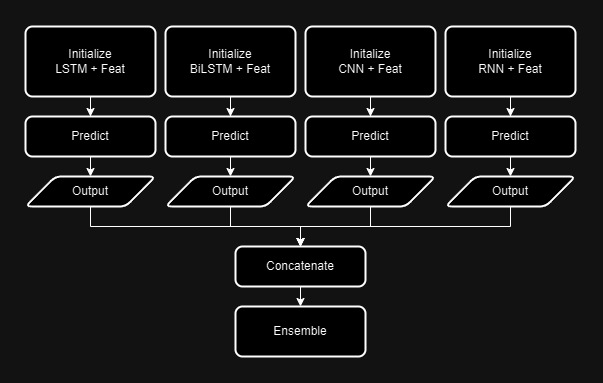

In [ ]:
# REFERENCE CODE
# import numpy as np

# # LSTM model
# lstm_model = create_lstm_branch(input_dim, output_dim, input_length, embedding_matrix)
# lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
# lstm_predictions_train = lstm_model.predict(X_train)
# lstm_predictions_test = lstm_model.predict(X_test)

# # CNN model
# cnn_model = create_cnn_branch(input_dim, output_dim, input_length, embedding_matrix)
# cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
# cnn_predictions_train = cnn_model.predict(X_train)
# cnn_predictions_test = cnn_model.predict(X_test)

# # Combine the predictions of all models into a new feature set
# train_meta_features = np.hstack([lstm_predictions_train, cnn_predictions_train])
# test_meta_features = np.hstack([lstm_predictions_test, cnn_predictions_test])

# # Define the meta-model
# meta_model = DecisionTreeClassifier()

# # Train the meta-model on the new feature set (predictions from the DL models)
# meta_model.fit(train_meta_features, np.argmax(y_train, axis=1))  # Assuming y_train is one-hot encoded

# # Predict using the meta-model
# meta_predictions = meta_model.predict(test_meta_features)

In [ ]:
# Initialize a dictionary to hold predictions by method
predictions_by_method = {
    'TF-IDF_1': {
        'train': {},
        'test': {},
        'probabilities': {}
    },
    'TF-IDF_2': {
        'train': {},
        'test': {},
        'probabilities': {}
    },
    'BOW': {
        'train': {},
        'test': {},
        'probabilities': {}
    },
    'Word2Vec_CBOW': {
        'train': {},
        'test': {},
        'probabilities': {}
    },
    'Word2Vec_SkipGram': {
        'train': {},
        'test': {},
        'probabilities': {}
    },
}

# Iterate over each model and non-embedding feature set
for model_name, create_model_fn in dl_models.items():
    for key, data in non_embeddings.items():
        print(f"Training {model_name} with {key} features")

        # Define branches
        text_model = create_model_fn(len(tokenizer.word_index) + 1, 128, X_train_pad.shape[1])
        feature_model = create_feature_branch(data["train"].shape[1])

        # Combine the branches
        combined = Concatenate()([text_model.output, feature_model.output])
        z = Dense(32, activation="relu")(combined)
        z = Dense(3, activation="softmax")(z)
        model = Model(inputs=[text_model.input, feature_model.input], outputs=z)

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(
            x=[X_train_pad, data["train"]], y=y_train_categorical,
            epochs=10, batch_size=32, validation_split=0.2
        )

        # Get predictions for training data (for stacking)
        y_train_pred = model.predict([X_train_pad, data["train"]])
        y_train_pred_classes = np.argmax(y_train_pred, axis=1)
        predictions_by_method[key]['train'][model_name] = y_train_pred_classes

        # Get predictions for test data (for voting and stacking)
        y_test_pred = model.predict([X_test_pad, data["test"]])
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)
        predictions_by_method[key]['test'][model_name] = y_test_pred_classes

        # Save probabilities of test data (for voting)
        predictions_by_method[key]['probabilities'][model_name] = y_test_pred

Training LSTM with BOW features
Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.7776 - loss: 0.6363 - val_accuracy: 0.9152 - val_loss: 0.2377
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.9425 - loss: 0.1780 - val_accuracy: 0.9725 - val_loss: 0.0721
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.9702 - loss: 0.0916 - val_accuracy: 0.9931 - val_loss: 0.0312
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.9795 - loss: 0.0603 - val_accuracy: 0.9940 - val_loss: 0.0275
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 44s 90ms/step - accuracy: 0.9836 - loss: 0.0473 - val_accuracy: 0.9918 - val_loss: 0.0251
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.9845 - loss: 0.0410 - val_accuracy: 0.9940 - val_loss: 0.0225
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.9881 - loss: 0.0361 - val_accuracy: 0.9940 - val_loss: 0.0255
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - ac

In [ ]:
for model_name, create_model in dl_models.items():
    for key, embedding_info in word_embeddings.items():
        print(f"Training {model_name} with {key} embeddings")

        # Create the model
        model_branch = create_model(
            input_dim=embedding_info['rows'],
            output_dim=embedding_info['cols'],
            input_length=X_train_pad.shape[1],
            embedding_matrix=embedding_info['matrix']
        )

        # Add a Dense layer for classification
        inputs = model_branch.input
        x = model_branch.output
        x = Dense(3, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=x)

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pad, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)

        # Get predictions for training data (for stacking)
        y_train_pred = model.predict(X_train_pad)
        y_train_pred_classes = np.argmax(y_train_pred, axis=1)
        predictions_by_method[key]['train'][model_name] = y_train_pred_classes

        # Get predictions for test data (for voting and stacking)
        y_test_pred = model.predict(X_test_pad)
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)
        predictions_by_method[key]['test'][model_name] = y_test_pred_classes

        # Save probabilities of test data (for voting)
        predictions_by_method[key]['probabilities'][model_name] = y_test_pred  # Store probabilities

Training LSTM with Word2Vec_CBOW embeddings
Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.6521 - loss: 0.8065 - val_accuracy: 0.5159 - val_loss: 1.1107
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.7963 - loss: 0.5764 - val_accuracy: 0.0645 - val_loss: 1.5150
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7757 - loss: 0.6052 - val_accuracy: 0.5667 - val_loss: 1.2049
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8165 - loss: 0.5490 - val_accuracy: 0.5254 - val_loss: 1.0423
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.8367 - loss: 0.4821 - val_accuracy: 0.6011 - val_loss: 0.9011
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8422 - loss: 0.4607 - val_accuracy: 0.6201 - val_loss: 0.8283
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8481 - loss: 0.4413 - val_accuracy: 0.6274 - val_loss: 0.8304
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 41

In [ ]:
print(f"Shape of X_train_pad: {X_train_pad.shape}")
print(f"Shape of X_test_pad: {X_test_pad.shape}")


Shape of X_train_pad: (11619, 59)
Shape of X_test_pad: (1496, 59)


In [ ]:
# Encode Test Class
test_encoder = LabelEncoder()
test_encoder.fit(y_test)
y_test_classes = test_encoder.transform(y_test)

# Encode Train Class
train_encoder = LabelEncoder()
train_encoder.fit(y_train)
y_train_classes = train_encoder.transform(y_train)

In [ ]:
 saved_prediction_by_method = predictions_by_method

In [ ]:
print(f"y_test_classes shape: {y_test_classes.shape}")
print(f"final_soft_predictions shape: {final_soft_predictions.shape}")
print(f"{len(predictions_by_method['Word2Vec_SkipGram']['probabilities']['RNN'])}")

y_test_classes shape: (1496,)
final_soft_predictions shape: (1496,)
1496


In [ ]:
# Soft Voting
for method, data in predictions_by_method.items():
    model_probabilities = data['probabilities']

    # Check if model_probabilities is not empty
    if model_probabilities:
        mean_probabilities = np.mean(list(model_probabilities.values()), axis=0)
        mean_probabilities_by_method[method] = mean_probabilities
        final_soft_predictions = np.argmax(mean_probabilities, axis=1)
        accuracy = accuracy_score(y_test_classes, final_soft_predictions)
    else:
        # If empty, set accuracy to "N/A" and print the message
        accuracy = "N/A"

    print(f"Soft Voting Accuracy for {method}: {accuracy}")

Soft Voting Accuracy for TF-IDF_1: 0.8709893048128342
Soft Voting Accuracy for TF-IDF_2: 0.8709893048128342
Soft Voting Accuracy for BOW: 0.8622994652406417
Soft Voting Accuracy for Word2Vec_CBOW: 0.8823529411764706
Soft Voting Accuracy for Word2Vec_SkipGram: 0.8903743315508021


In [ ]:
# Hard Voting
hard_voting_test_preds = {}

# Iterate through each method in predictions_by_method
for method, data in predictions_by_method.items():
    hard_voting_test_preds[method] = []
    predicted_classes_dict = data['test']

    if not predicted_classes_dict:
        accuracy = 'N/A'
    else:
        predicted_classes_list = list(predicted_classes_dict.values())
        for i in range(len(predicted_classes_list[0])):
            votes = [preds[i] for preds in predicted_classes_list]
            final_pred_class = np.argmax(np.bincount(votes))
            hard_voting_test_preds[method].append(final_pred_class)
        accuracy = accuracy_score(y_test_classes, hard_voting_test_preds[method])

    print(f"Hard Voting Accuracy for {method}: {accuracy}")

Hard Voting Accuracy for TF-IDF_1: 0.8676470588235294
Hard Voting Accuracy for TF-IDF_2: 0.8683155080213903
Hard Voting Accuracy for BOW: 0.856951871657754
Hard Voting Accuracy for Word2Vec_CBOW: 0.8729946524064172
Hard Voting Accuracy for Word2Vec_SkipGram: 0.8803475935828877


In [ ]:
ensemble_base_models = {
    'SVM': SVC(probability=True, random_state=RANDOM_SEED),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED)
}


In [ ]:
# Stacking
stacking_accuracies_by_method = {}

# Iterate over each method in predictions_by_method
for method, data in predictions_by_method.items():
    method_train_preds = data['train']
    method_test_preds = data['test']

    # Check if there are any predictions available
    if not method_train_preds or not method_test_preds:
        stacking_accuracies_by_method[method] = {model_name: 'N/A' for model_name in ensemble_base_models.keys()}
        continue

    # Convert dictionary values to lists
    method_train_preds_list = list(method_train_preds.values())
    method_test_preds_list = list(method_test_preds.values())
    X_train_meta = np.column_stack(method_train_preds_list)
    X_test_meta = np.column_stack(method_test_preds_list)
    method_accuracies = {}

    # Train and evaluate each ensemble model on the current method's meta-features
    for model_name, base_model in ensemble_base_models.items():
        base_model.fit(X_train_meta, y_train)
        y_test_pred_base = base_model.predict(X_test_meta)
        accuracy = accuracy_score(y_test, y_test_pred_base)
        method_accuracies[model_name] = accuracy

    # Store accuracies for the current method in the main dictionary
    stacking_accuracies_by_method[method] = method_accuracies

# Display all stacking accuracies for each method and model
print("\nStacking Accuracies for All Methods:")
for method, accuracies in stacking_accuracies_by_method.items():
    print(f"\n{method}:")
    for model_name, accuracy in accuracies.items():
        print(f"{model_name}: {accuracy}")



Stacking Accuracies for All Methods:

TF-IDF_1:
SVM: 0.8536096256684492
Gradient Boosting: 0.8643048128342246
Random Forest: 0.8582887700534759
Logistic Regression: 0.858957219251337

TF-IDF_2:
SVM: 0.8556149732620321
Gradient Boosting: 0.8643048128342246
Random Forest: 0.8683155080213903
Logistic Regression: 0.8643048128342246

BOW:
SVM: 0.8562834224598931
Gradient Boosting: 0.8629679144385026
Random Forest: 0.8596256684491979
Logistic Regression: 0.8556149732620321

Word2Vec_CBOW:
SVM: 0.8435828877005348
Gradient Boosting: 0.8435828877005348
Random Forest: 0.8429144385026738
Logistic Regression: 0.8475935828877005

Word2Vec_SkipGram:
SVM: 0.857620320855615
Gradient Boosting: 0.857620320855615
Random Forest: 0.857620320855615
Logistic Regression: 0.857620320855615


# Graveyard (unused code)

In [ ]:
## Word2Vec
# w2v_model = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4)

# def get_w2v_features(texts, model):
#     features = []
#     for text in texts:
#         words = text.split()
#         word_vectors = [model.wv[word] for word in words if word in model.wv]
#         if word_vectors:
#             features.append(np.mean(word_vectors, axis=0))
#         else:
#             features.append(np.zeros(model.vector_size))
#     return np.array(features)

# X_train_w2v = get_w2v_features(X_train, w2v_model)
# X_test_w2v = get_w2v_features(X_test, w2v_model)

In [ ]:
# # TF-IDF
# tfidf_vectorizer = TfidfVectorizer()
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# # Prepare data for DL models
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)
# X_seq = tokenizer.texts_to_sequences(X_train)
# X_pad = pad_sequences(X_seq)

# # Convert labels to numerical format
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_train)
# y_categorical = to_categorical(y_encoded)

# # LSTM
# lstm_model = Sequential([
#     Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=X_pad.shape[1]),
#     LSTM(100),
#     Dense(3, activation='softmax')
# ])
# lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# lstm_model.fit(X_pad, y_categorical, epochs=10, batch_size=32, validation_split=0.2)

# # Simple RNN
# rnn_model = Sequential([
#     Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=X_pad.shape[1]),
#     SimpleRNN(100),
#     Dense(3, activation='softmax')
# ])
# rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# rnn_model.fit(X_pad, y_categorical, epochs=10, batch_size=32, validation_split=0.2)

# # CNN
# cnn_model = Sequential([
#     Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=X_pad.shape[1]),
#     Conv1D(128, 5, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dense(3, activation='softmax')
# ])
# cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# cnn_model.fit(X_pad, y_categorical, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate DL models
# X_test_seq = tokenizer.texts_to_sequences(X_test)
# X_test_pad = pad_sequences(X_test_seq, maxlen=X_pad.shape[1])

# for name, model in [('LSTM', lstm_model), ('RNN', rnn_model), ('CNN', cnn_model)]:
#     y_pred = model.predict(X_test_pad)
#     y_pred_classes = np.argmax(y_pred, axis=1)
#     y_test_classes = np.argmax(to_categorical(label_encoder.transform(y_test)), axis=1)
#     print(f"\n{name} Results:")
#     print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))